In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score)
from tensorflow.keras.optimizers import Adam
from functions.displayer import (plot_cycle,
                                 plot_loss,
                                 plot_reconstruction,
                                 plot_mae_per_cycle)
from functions.data_processor import DataProcessor
from models.encoder import ConvEncoder
from models.decoder import ConvDecoder
from models.autoencoder import Autoencoder
from functions.reconstruction import (calc_avg_mae_per_cycle)

In [2]:
# PATHs
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'

<h1><center>Unsupervised anomaly detection using Conv1D-based autoencoders</center></h1>
<h3><center>Multivariate time series - Wafers</center></h3>

-------

## I. Data preparation

#### 1. Data reading

- Read csv files

In [3]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

- Extract X and y

In [4]:
# Training set
x_train = train[['id', 'value']]
y_train = train.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])
# Testing set
x_test = test[['id', 'value']]
y_test = test.groupby(['id']).apply(lambda X: X.isAnomaly.iloc[0])

#### 2. Data description

Data contains a calculated measure based on multiple sensors. This measure is **cyclic** with **152 timestamp per cycle**.

In [5]:
n_train_anomaly = y_train.value_counts()
n_test_anomaly = y_test.value_counts()

In [6]:
print('Train anomaly distribution: ', n_train_anomaly, sep='\n', end='\n\n')
print('Test anomaly distribution: ', n_test_anomaly, sep='\n')

Train anomaly distribution: 
 1    903
-1     97
dtype: int64

Test anomaly distribution: 
 1    5499
-1     665
dtype: int64


#### 3. Data visualization

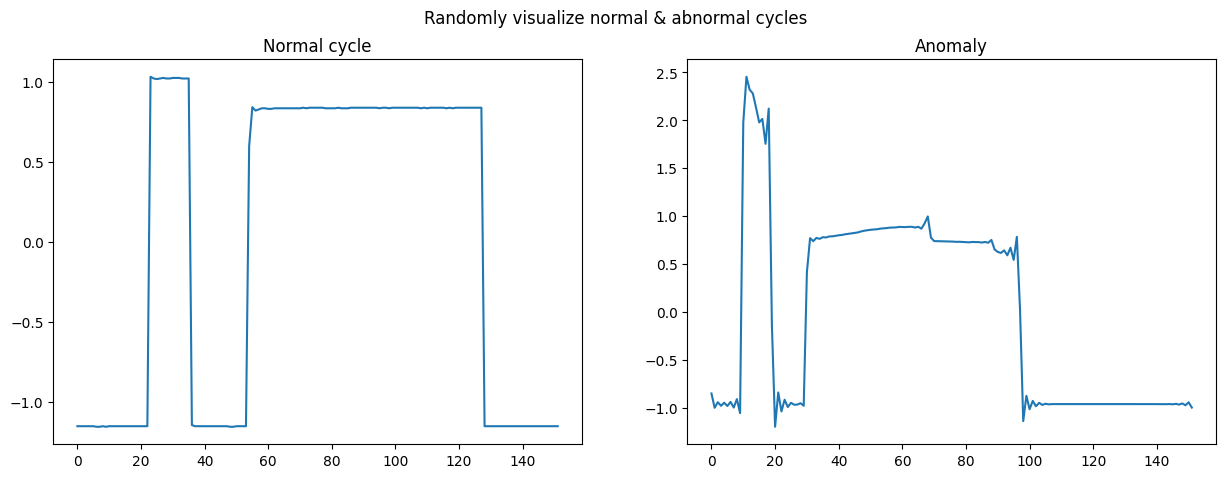

In [7]:
plot_cycle(train)

#### 4. Training set

- The training set for timeseries anomaly detection should be composed exclusively of normal cycles. Since the model's objective is to learn features intrinsic of normal cycles and learn to reconstruct the original series from a small latent space. The error would be higher if the cycle prove to be an anomaly.

In [8]:
x_train = x_train[train.isAnomaly==1].reset_index(drop=True)

#### 5. Data processing 

- Data proccessor parameters

In [9]:
col_names = ['value']
id = 'id'

- Create data processor

In [10]:
dp = DataProcessor(x_train, x_test, col_names, id)

- Scaling data

In [11]:
dp.scale_data()

- Reshaping data

In [12]:
dp.reshape_data()
print(dp.s_train.shape)

(903, 152, 1)


## II. Training an auto-encoder

#### 0. Dimensions definition

In [13]:
# Training set shape
shape = dp.s_train.shape
# Sub sequence shape
length_sequence = shape[1]
n_features = shape[2]
# Latent dimension 
n_latent = 16

#### 1. Create an LSTM encoder

In [14]:
encoder = ConvEncoder(length_sequence, n_features, n_latent).model

In [15]:
encoder.summary()

Model: "Encoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 152, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 76, 64)            512       
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 64)            28736     
                                                                 
 dropout (Dropout)           (None, 38, 64)            0         
                                                                 
 batch_normalization (BatchN  (None, 38, 64)           256       
 ormalization)                                                   
                                                                 
 conv1d_2 (Conv1D)           (None, 19, 128)           41088     
                                                     

#### 2. Create an LSTM decoder

In [16]:
decoder = ConvDecoder(length_sequence, n_features, n_latent).model

In [17]:
decoder.summary()

Model: "Decoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 19)                323       
                                                                 
 reshape (Reshape)           (None, 19, 1)             0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 38, 128)          768       
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 76, 128)          82048     
 ranspose)                                                       
                                                                 
 dropout_2 (Dropout)         (None, 76, 128)         

#### 3. Create an auto-encoder

In [18]:
ae = Autoencoder(encoder, decoder).model

#### 4. Compile and explore the auto-encoder

In [19]:
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 152, 1)]          0         
                                                                 
 Encoder-Model (Functional)  (None, 16)                155216    
                                                                 
 Decoder-Model (Functional)  (None, 152, 1)            170244    
                                                                 
Total params: 325,460
Trainable params: 324,692
Non-trainable params: 768
_________________________________________________________________


#### 5. Fitting the model

- Training the model

In [20]:
history = ae.fit(x=dp.s_train,
                 y=dp.s_train,
                 batch_size=8,
                 epochs=20,
                 validation_data=(dp.s_test, dp.s_test))

Epoch 1/20
113/113 [==============================] - 7s 48ms/step - loss: 0.0495 - val_loss: 0.0154
Epoch 2/20
113/113 [==============================] - 5s 47ms/step - loss: 0.0124 - val_loss: 0.0126
Epoch 3/20
113/113 [==============================] - 5s 46ms/step - loss: 0.0098 - val_loss: 0.0151
Epoch 4/20
113/113 [==============================] - 6s 52ms/step - loss: 0.0088 - val_loss: 0.0145
Epoch 5/20
113/113 [==============================] - 6s 50ms/step - loss: 0.0075 - val_loss: 0.0091
Epoch 6/20
113/113 [==============================] - 6s 50ms/step - loss: 0.0055 - val_loss: 0.0084
Epoch 7/20
113/113 [==============================] - 7s 62ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 8/20
113/113 [==============================] - 6s 57ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 9/20
113/113 [==============================] - 6s 53ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 10/20
113/113 [==============================] - 6s 53ms/step - loss: 0.0035 - val_lo

- Plotting loss functions

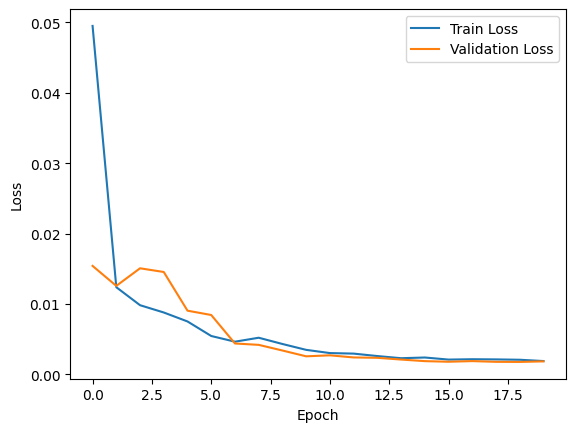

In [21]:
plot_loss(history)

#### 6. Test  windowed prediction

In [22]:
r_pred = ae.predict(dp.s_test)

193/193 [==============================] - 3s 16ms/step


## III. Reconstruction

#### 1. Transform windowed prediction into reconstructed cycles 

- Plotting reconstructed cycle

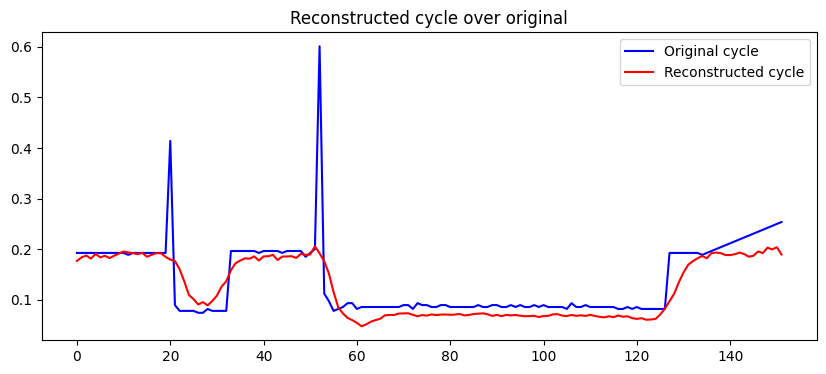

In [23]:
# Normal cycle
y_test_normal = y_test[y_test==1].index.tolist()
cycle = random.choice(y_test_normal)
plot_reconstruction(dp.s_test, r_pred, cycle)

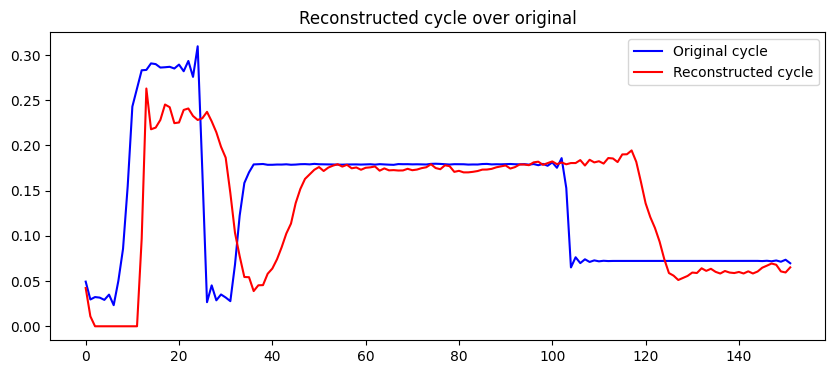

In [24]:
# Anomaly
y_test_anomaly = y_test[y_test==-1].index.tolist()
cycle = random.choice(y_test_anomaly)
plot_reconstruction(dp.s_test, r_pred, cycle)

#### 2. Average reconstruction error per cycle

- Calculate the average mean absolute error (MAE) per cycle between a set of original 3D sequences and their reconstructions.

In [25]:
mae_per_cycle = calc_avg_mae_per_cycle(dp.s_test, r_pred)

- Plotting the average reconstruction error per cycle

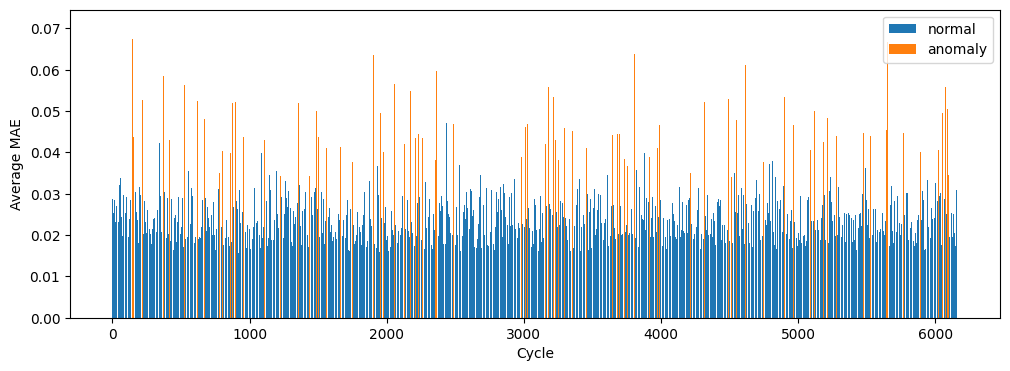

In [26]:
plot_mae_per_cycle(mae_per_cycle, y_test)

#### 3. Anomaly detection using a threshold on MAE per cycle

In [39]:
threshold = 0.037

In [40]:
y_pred = [1 if x<threshold else -1 for x in mae_per_cycle]

#### 4. Evaluation of anomaly detection using a threshold

In [41]:
accuracy = accuracy_score(y_test, y_pred)
confusion_m = confusion_matrix(y_test, y_pred)
cf_report = classification_report(y_test, y_pred)

In [42]:
print('Accuracy: %.2f' % accuracy, end='\n\n')
print('Confusion matrix: \n', confusion_m, end='\n\n')
print('Classification report: \n\n', cf_report)

Accuracy: 0.98

Confusion matrix: 
 [[ 603   62]
 [  89 5410]]

Classification report: 

               precision    recall  f1-score   support

          -1       0.87      0.91      0.89       665
           1       0.99      0.98      0.99      5499

    accuracy                           0.98      6164
   macro avg       0.93      0.95      0.94      6164
weighted avg       0.98      0.98      0.98      6164

